# Parameter Estimation of RIG Roll Experiments

## Setup and descriptions

* Without ACM model
* Turn on wind tunnel
* Only 1DoF for RIG roll movement
* Use **small-amplitude** aileron command of CMP as inputs (in degrees)
$$U = \delta_{a,cmp}(t)$$
* Consider RIG roll angle and its derivative as States (in radians)
$$X = \begin{pmatrix} \phi_{rig} \\ \dot{\phi}_{rig} \end{pmatrix}$$
* Observe RIG roll angle and its derivative as Outputs (in degrees)
$$Z = \begin{pmatrix} \phi_{rig} \\ \dot{\phi}_{rig} \end{pmatrix}$$
* Use output error method based on most-likehood(ML) to estimate
$$ \theta = \begin{pmatrix} C_{l,\delta_a,cmp} \\ C_{lp,cmp}  \end{pmatrix} $$

## Startup computation engines

In [ ]:
%run matt_startup
%run -i matt_utils

button_qtconsole()

#import other needed modules in all used engines
#with dview.sync_imports():
#   import os

## Data preparation

### Load raw data

In [2]:
filename = 'FIWT_Exp050_20150612160930.dat.npz'

def loadData():
    # Read and parse raw data
    global exp_data
    exp_data = np.load(filename)

    # Select colums
    global T_cmp, da1_cmp, da2_cmp, da3_cmp , da4_cmp
    T_cmp = exp_data['data33'][:,0]
    da1_cmp = exp_data['data33'][:,3]
    da2_cmp = exp_data['data33'][:,5]
    da3_cmp = exp_data['data33'][:,7]
    da4_cmp = exp_data['data33'][:,9]

    global T_rig, phi_rig
    T_rig = exp_data['data44'][:,0]
    phi_rig = exp_data['data44'][:,2]

loadData()

In [3]:
text_loadData()

### Check time sequence and inputs/outputs

Click 'Check data' button to show the raw data. 

Click on curves to select time point and push into queue; click 'T/s' text to pop up last point in the queue; and click 'Output' text to print time sequence table.

In [4]:
def checkInputOutputData():

    #check inputs/outputs
    fig, ax = plt.subplots(2,1,True)
    ax[0].plot(T_cmp,da1_cmp,'r', T_cmp,da2_cmp,'g',
               T_cmp,da3_cmp,'b', T_cmp,da4_cmp,'m',
               picker=1)
    ax[1].plot(T_rig,phi_rig, 'b', picker=2)
    ax[0].set_ylabel('$\delta \/ / \/ ^o$')
    ax[1].set_ylabel('$\phi \/ / \/ ^o/s$')
    ax[1].set_xlabel('$T \/ / \/ s$', picker=True)
    ax[0].set_title('Output', picker=True)
    

    fig.canvas.mpl_connect('pick_event', onPickTime)
    fig.show()
    display(fig)

button_CheckData()

### Input $\delta_T$ and focused time ranges

In [5]:
# Pick up focused time ranges
time_marks = [
[28.4202657857,88.3682684612,"ramp cmp1 u"],
[90.4775063395,150.121612502,"ramp cmp1 d"],
[221.84785848,280.642700604,"ramp cmp2 u"],
[283.960460465,343.514106772,"ramp cmp2 d"],
[345.430891556,405.5707005,"ramp cmp3 u"],
[408.588176529,468.175897568,"ramp cmp3 d"],
[541.713519906,600.757388552,"ramp cmp4 u"],
[604.040332533,663.913079475,"ramp cmp4 d"],
[677.817484542,778.026124493,"ramp cmp1/3 d"],
[780.09665253,879.865190551,"ramp cmp1/3 u"],
[888.075513916,987.309008866,"ramp cmp2/4 d"],
[989.75879072,1088.99649253,"ramp cmp2/4 u"],
[1101.9320102,1221.45089264,"ramp cmpall u"],
[1240.32935658,1360.72513252,"ramp cmpall d"],
]

# Decide DT,U,Z and their processing method
DT=0.2
process_set = {
            'U':[(T_cmp, da1_cmp,0),
                (T_cmp, da2_cmp,0),
                (T_cmp, da3_cmp,0),
                (T_cmp, da4_cmp,0),],
            'Z':[(T_rig, phi_rig,1),],
            'cutoff_freq': 1 #Hz
           }

U_names = ['$\delta_{a1,cmp} \, / \, ^o$',
          '$\delta_{a2,cmp} \, / \, ^o$',
          '$\delta_{a3,cmp} \, / \, ^o$',
          '$\delta_{a4,cmp} \, / \, ^o$']
Y_names = Z_names = ['$\phi_{a,rig} \, / \, ^o$']

display_data_prepare()

<IPython.core.display.Math object>

Idx,Start(s),Spam(s),Description
0,28.42,59.95,ramp cmp1 u
1,90.48,59.64,ramp cmp1 d
2,221.85,58.79,ramp cmp2 u
3,283.96,59.55,ramp cmp2 d
4,345.43,60.14,ramp cmp3 u
5,408.59,59.59,ramp cmp3 d
6,541.71,59.04,ramp cmp4 u
7,604.04,59.87,ramp cmp4 d
8,677.82,100.21,ramp cmp1/3 d
9,780.10,99.77,ramp cmp1/3 u


$U$
"$\delta_{a1,cmp} \, / \, ^o$"
"$\delta_{a2,cmp} \, / \, ^o$"
"$\delta_{a3,cmp} \, / \, ^o$"
"$\delta_{a4,cmp} \, / \, ^o$"


$Z$
"$\phi_{a,rig} \, / \, ^o$"


## Resample and filter data in sections

For each section,
* Select time range and shift it to start from zero;
* Resample Time, Inputs, Outputs in unique $\delta_T$;
* Smooth Input/Observe data if flag bit0 is set;
* Take derivatives of observe data if flag bit1 is set.

In [6]:
resample(True);

## Define dynamic model to be estimated

$$\left\{\begin{matrix}\begin{align}
M_{x,rig} &= M_{x,a} + M_{x,f} + M_{x,cg} = 0 \\
M_{x,a} &= \frac{1}{2} \rho V^2S_cb_c  C_{la,cmp}\delta_{a,cmp} \\
M_{x,f} &= -F_c \, sign(\dot{\phi}_{rig}) \\
M_{x,cg} &= -m_T g  l_{zT} \sin \left ( \phi - \phi_0 \right )
\end{align}\end{matrix}\right.$$



In [14]:
%%px --local
#update common const parameters in all engines

angles = range(-40,41,5)
angles[0] -= 1
angles[-1] += 1
del angles[angles.index(0)]
angles_num = len(angles)

#problem size
Nx = 0
Nu = 4
Ny = 1
Npar = 4*angles_num+1

#reference
S_c = 0.1254   #S_c(m2) 
b_c = 0.7      #b_c(m)
g = 9.81       #g(m/s2)

#static measurement
m_T = 9.585   #m_T(kg)
l_z_T = 0.0416 #l_z_T(m)
V = 25         #V(m/s)

#previous estimations
F_c = 0.06 #F_c(N*m)
Clda_cmp = -0.2966 #Clda_cmp(1/rad)
kFbrk = 1.01
shuffle = 0.01

#other parameters

qbarSb = 0.5*1.225*V*V*S_c*b_c
_m_T_l_z_T_g = -(m_T*l_z_T)*g


def obs(Z,T,U,params):
    s = T.size
    
    k1 = np.array(params[0:angles_num])
    k2 = np.array(params[angles_num:angles_num*2])
    k3 = np.array(params[angles_num*2:angles_num*3])
    k4 = np.array(params[angles_num*3:angles_num*4])
    phi0 = params[-1]

    Clda1 = scipy.interpolate.interp1d(angles, Clda_cmp*0.00436332313*k1*angles,assume_sorted=True)
    Clda2 = scipy.interpolate.interp1d(angles, Clda_cmp*0.00436332313*k2*angles,assume_sorted=True)
    Clda3 = scipy.interpolate.interp1d(angles, Clda_cmp*0.00436332313*k3*angles,assume_sorted=True)
    Clda4 = scipy.interpolate.interp1d(angles, Clda_cmp*0.00436332313*k4*angles,assume_sorted=True)
    
    moments_a = qbarSb*(Clda1(U[1:s,0])+Clda2(U[1:s,1])
                       +Clda3(U[1:s,2])+Clda4(U[1:s,3]))

    phi = Z[0,0]*0.0174533
    phi_rslt = [phi]
    for t,m_a in itertools.izip(T[1:],moments_a):
        moments_cg = _m_T_l_z_T_g*math.sin(phi-phi0)
        if moments_cg + m_a > F_c*kFbrk:
            k = ( F_c-m_a)/_m_T_l_z_T_g
            if k > 1:
                k = 1
            elif k < -1:
                k = -1
            phi = phi0+math.asin(k)
        elif moments_cg + m_a < -F_c*kFbrk:
            k = (-F_c-m_a)/_m_T_l_z_T_g
            if k > 1:
                k = 1
            elif k < -1:
                k = -1
            phi = phi0+math.asin(k)
        else :
            phi += (moments_cg + m_a)/(F_c*kFbrk)*shuffle/57.3
        phi_rslt.append(phi)
    
    return (np.array(phi_rslt)*57.3).reshape((-1,1))



In [15]:
display(HTML('<b>Constant Parameters</b>'))
table = ListTable()
table.append(['Name','Value','unit'])
table.append(['$S_c$',S_c,'$m^2$'])
table.append(['$b_c$',b_c,'$m$'])
table.append(['$g$',g,'$m/s^2$'])
table.append(['$m_T$',m_T,'$kg$'])
table.append(['$l_{zT}$',l_z_T,'$m$'])
table.append(['$V$',V,'$m/s$'])
table.append(['$F_c$',F_c,'$Nm$'])
table.append(['$C_{l \delta a,cmp}$',Clda_cmp,'$rad^{-1}$'])
display(table)


Name,Value,unit
$S_c$,0.1254,$m^2$
$b_c$,0.7,$m$
$g$,9.81,$m/s^2$
$m_T$,9.585,$kg$
$l_{zT}$,0.0416,$m$
$V$,25,$m/s$
$F_c$,0.06,$Nm$
"$C_{l \delta a,cmp}$",-0.2966,$rad^{-1}$


# Initial guess

* Input default values and ranges for parameters
* Select sections for trainning
* Adjust parameters based on simulation results
* Decide start values of parameters for optimization

In [16]:
#initial guess
param0 = [1]*(4*angles_num)+[0]

param_name = ['k_{}_{}'.format(i/angles_num+1, angles[i%angles_num]) for i in range(4*angles_num)] + ['$phi_0$']
param_unit = ['1']*(4*angles_num) + ['$rad$']

NparID = Npar
opt_idx = range(Npar)
opt_param0 = [param0[i] for i in opt_idx]
par_del = [0.001]*(4*angles_num) + [0.0001]
bounds =  [(0,1.5)]*(4*angles_num) +[(-0.1, 0.1)]
display_default_params()

#select sections for training
section_idx = range(8)
del section_idx[3]
display_data_for_train()

#push parameters to engines
push_opt_param()

Idx,Description,$x_0$,unit,opt,$\delta_{par}$,min,max
0,k_1_-41,1,1,*,0.001,0,1.5
1,k_1_-35,1,1,*,0.001,0,1.5
2,k_1_-30,1,1,*,0.001,0,1.5
3,k_1_-25,1,1,*,0.001,0,1.5
4,k_1_-20,1,1,*,0.001,0,1.5
5,k_1_-15,1,1,*,0.001,0,1.5
6,k_1_-10,1,1,*,0.001,0,1.5
7,k_1_-5,1,1,*,0.001,0,1.5
8,k_1_5,1,1,*,0.001,0,1.5
9,k_1_10,1,1,*,0.001,0,1.5


Idx,Start(s),Spam(s),Description
0,28.42,59.95,ramp cmp1 u
1,90.48,59.64,ramp cmp1 d
2,221.85,58.79,ramp cmp2 u
4,345.43,60.14,ramp cmp3 u
5,408.59,59.59,ramp cmp3 d
6,541.71,59.04,ramp cmp4 u
7,604.04,59.87,ramp cmp4 d


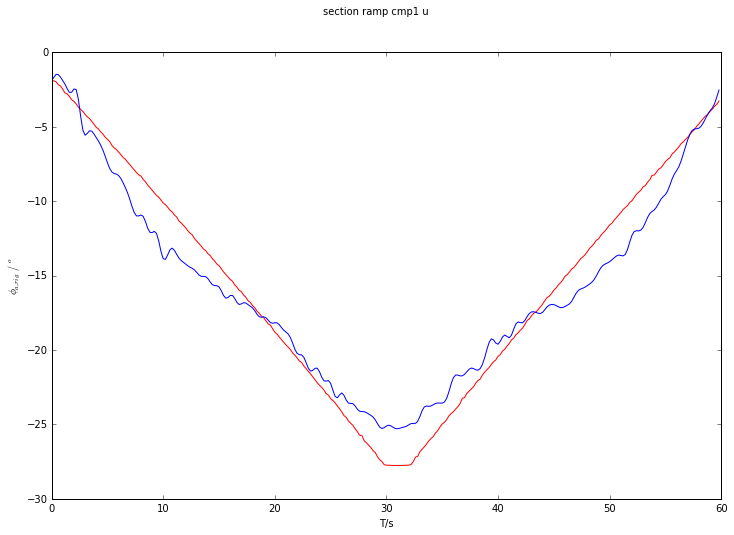

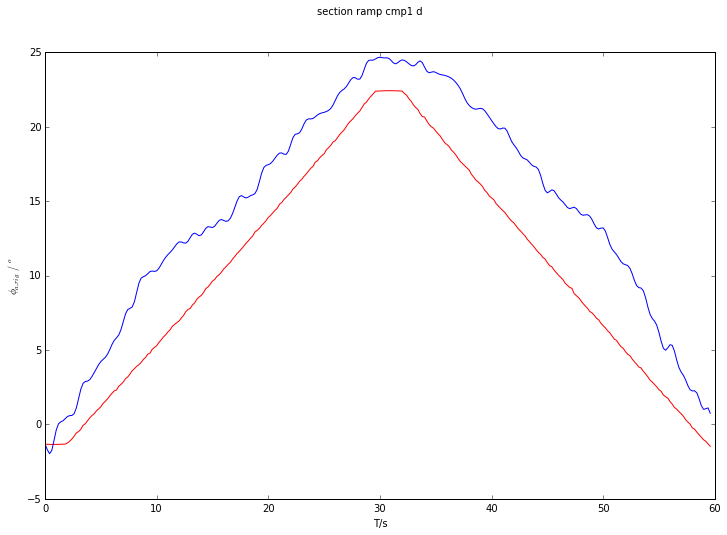

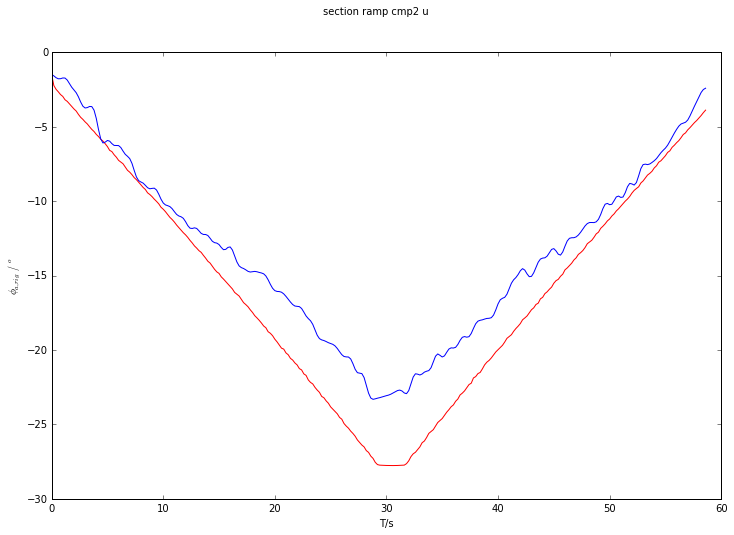

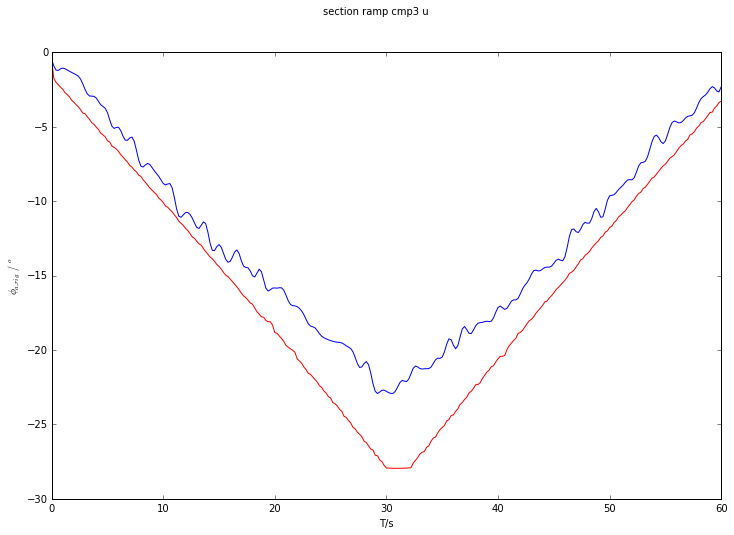

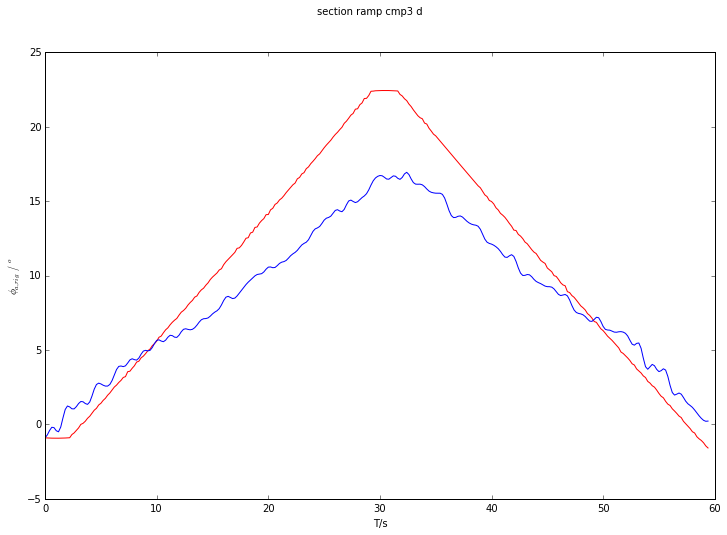

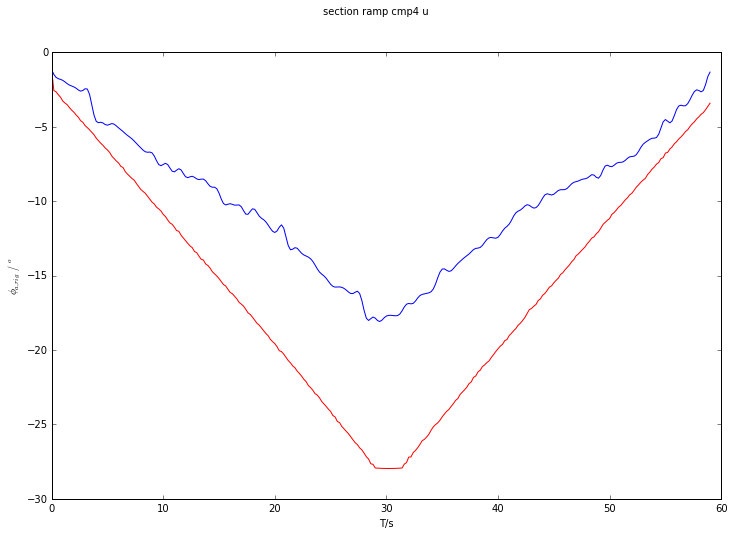

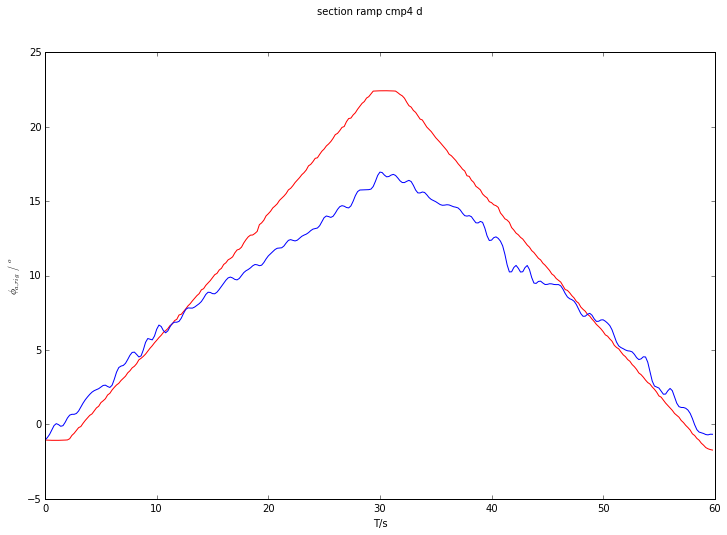

In [17]:
# select 4 section from training data
#idx = random.sample(section_idx, 4)
idx = section_idx[:]

interact_guess();

# Optimize using ML

In [18]:
display_preopt_params()

if False:
    InfoMat = None
    method = 'trust-ncg'
    def hessian(opt_params, index):
        global InfoMat
        return InfoMat
    dview['enable_infomat']=True
    options={'gtol':1}
    opt_bounds = None
else:
    method = 'L-BFGS-B'
    hessian = None
    dview['enable_infomat']=False
    options={'ftol':1e-6,'maxfun':400}
    opt_bounds = bounds

cnt = 0
tmp_rslt = None
T0 = time.time()
print('#cnt,     Time,      |R|')

%time res =  sp.optimize.minimize(fun=costfunc, x0=opt_param0, \
        args=(opt_idx,), method=method, jac=True, hess=hessian, \
        bounds=opt_bounds, options=options)


Idx,Description,$x_0$,unit,opt,$\delta_{par}$,min,max
0,k_1_-41,1.0,1,*,0.001,0,1.5
1,k_1_-35,1.0,1,*,0.001,0,1.5
2,k_1_-30,1.0,1,*,0.001,0,1.5
3,k_1_-25,1.0,1,*,0.001,0,1.5
4,k_1_-20,1.0,1,*,0.001,0,1.5
5,k_1_-15,1.0,1,*,0.001,0,1.5
6,k_1_-10,1.0,1,*,0.001,0,1.5
7,k_1_-5,1.0,1,*,0.001,0,1.5
8,k_1_5,1.0,1,*,0.001,0,1.5
9,k_1_10,1.0,1,*,0.001,0,1.5


#cnt,     Time,      |R|
0001,    0.152,       13.8
0002,    0.294,      400.9
0003,    0.438,       12.5
0004,    0.578,        5.5
0005,    0.725,        5.3
0006,    0.867,        7.1
0007,    1.003,        5.3
0008,    1.142,        5.0
0009,    1.282,        4.4
0010,    1.424,        4.3
0011,    1.567,        3.8
0012,    1.719,        3.8
0013,    1.875,        3.8
0014,    2.021,        3.8
0015,    2.173,        3.8
0016,    2.317,        3.8
0017,    2.470,        3.8
0018,    2.623,        3.8
0019,    2.764,        3.8
0020,    2.905,        3.8
0021,    3.048,        3.8
0022,    3.198,        3.8
0023,    3.353,        3.8
0024,    3.508,        3.8
0025,    3.650,        3.8
0026,    3.789,        3.8
0027,    3.927,        3.8
0028,    4.064,        3.8
0029,    4.206,        3.8
0030,    4.347,        3.8
0031,    4.490,        3.8
0032,    4.628,      249.1
0033,    4.767,       19.4
0034,    4.909,        4.9
0035,    5.065,        3.5
0036,    5.205,        2.9
003

## Show and test results

Idx,Description,$x$
0,k_1_-41,1.01114537558
1,k_1_-35,1.06964977738
2,k_1_-30,1.13337426265
3,k_1_-25,1.19943077017
4,k_1_-20,1.22000196622
5,k_1_-15,1.24991354029
6,k_1_-10,1.23143272329
7,k_1_-5,1.03755684016
8,k_1_5,0.846035509447
9,k_1_10,1.2617931813


Idx,Start(s),Spam(s),Description
0,28.42,59.95,ramp cmp1 u
1,90.48,59.64,ramp cmp1 d
2,221.85,58.79,ramp cmp2 u
3,283.96,59.55,ramp cmp2 d
4,345.43,60.14,ramp cmp3 u
5,408.59,59.59,ramp cmp3 d
6,541.71,59.04,ramp cmp4 u
7,604.04,59.87,ramp cmp4 d
8,677.82,100.21,ramp cmp1/3 d
9,780.10,99.77,ramp cmp1/3 u


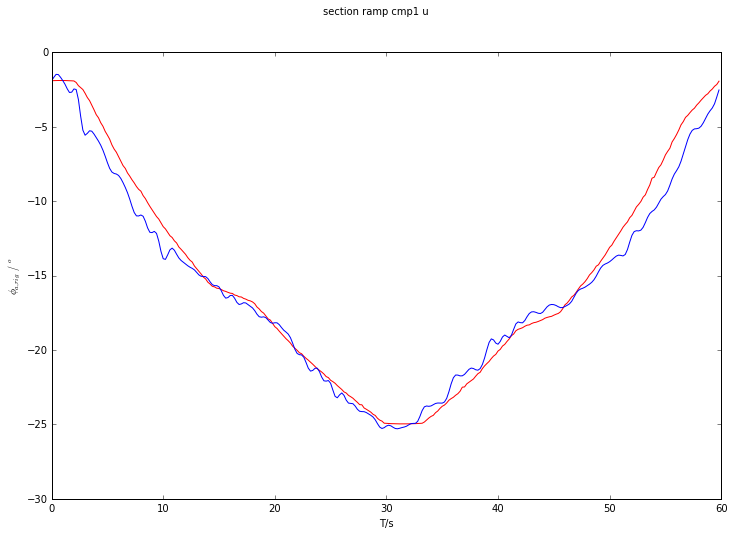

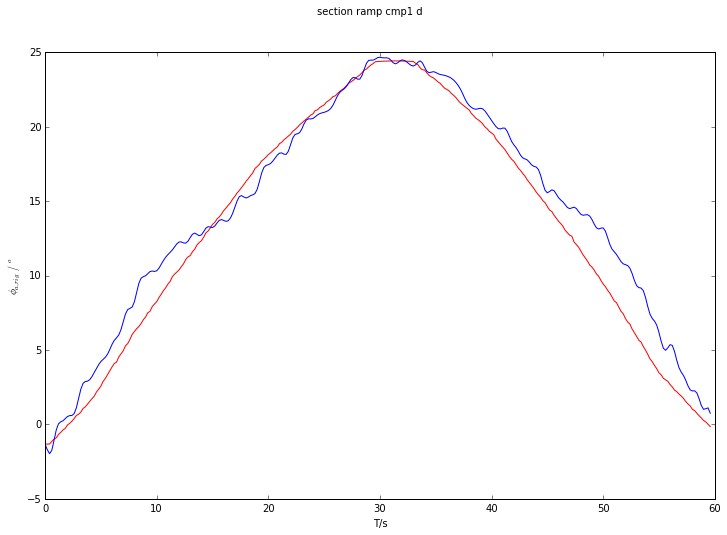

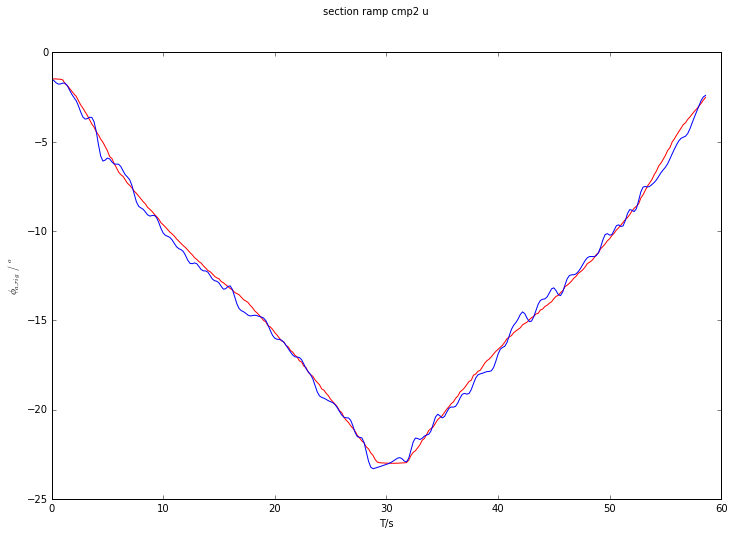

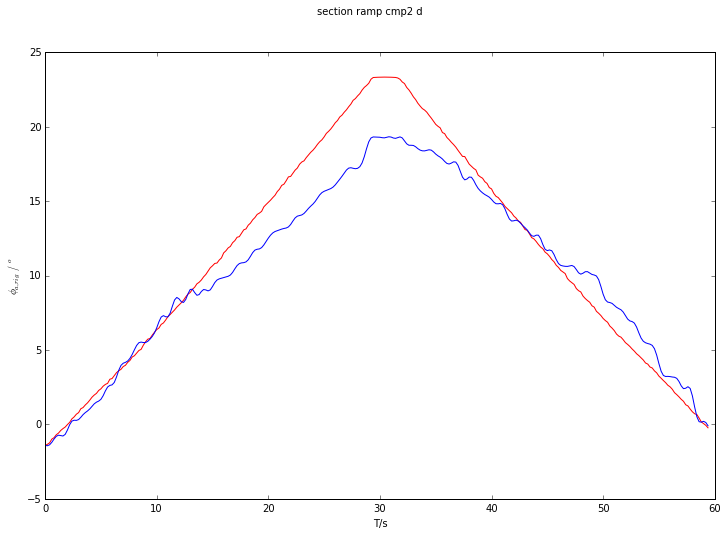

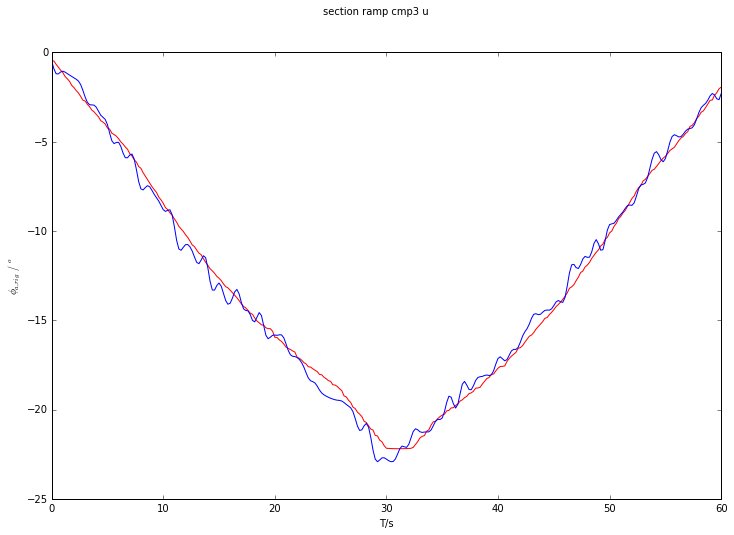

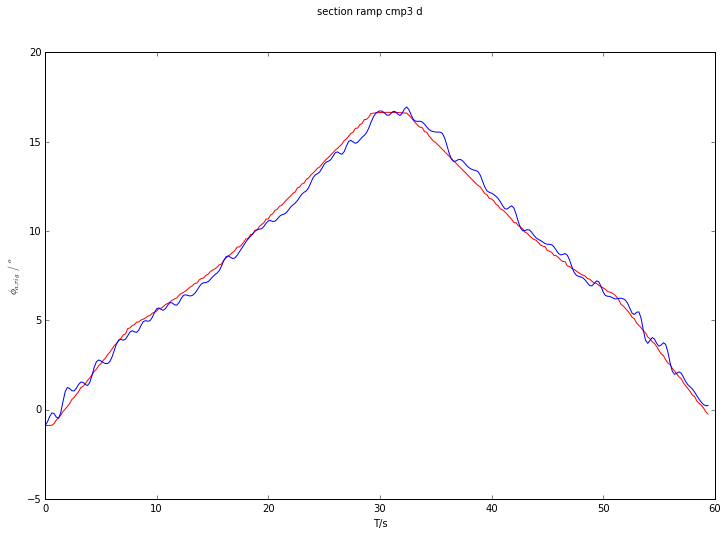

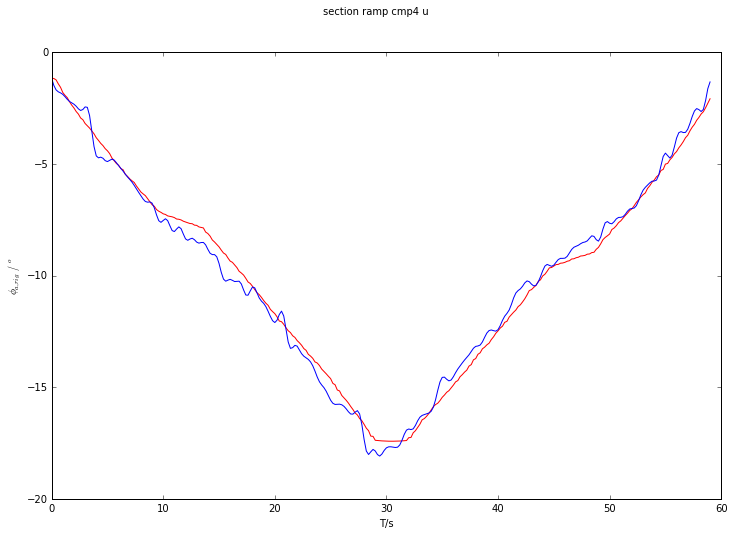

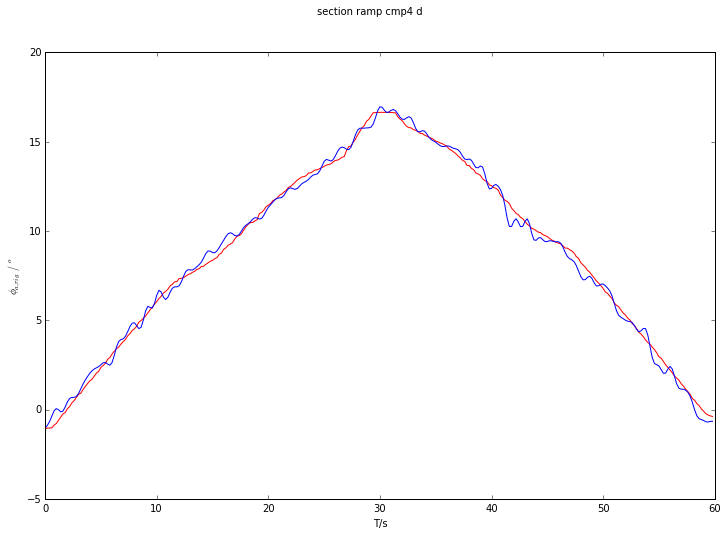

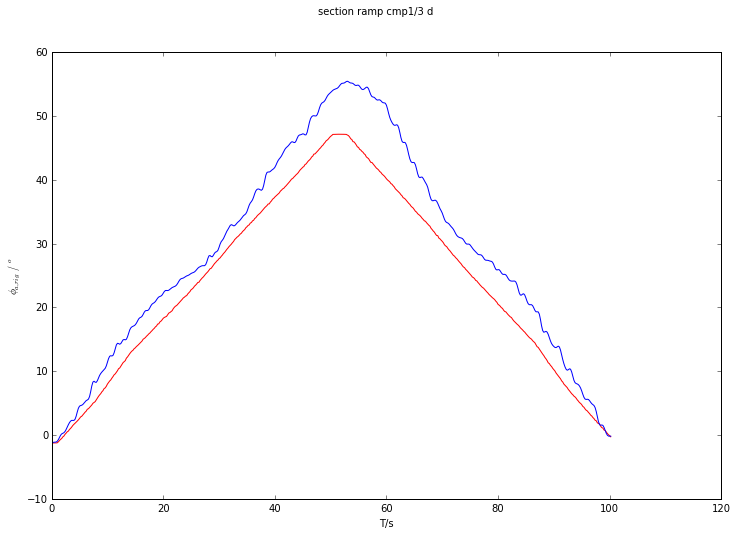

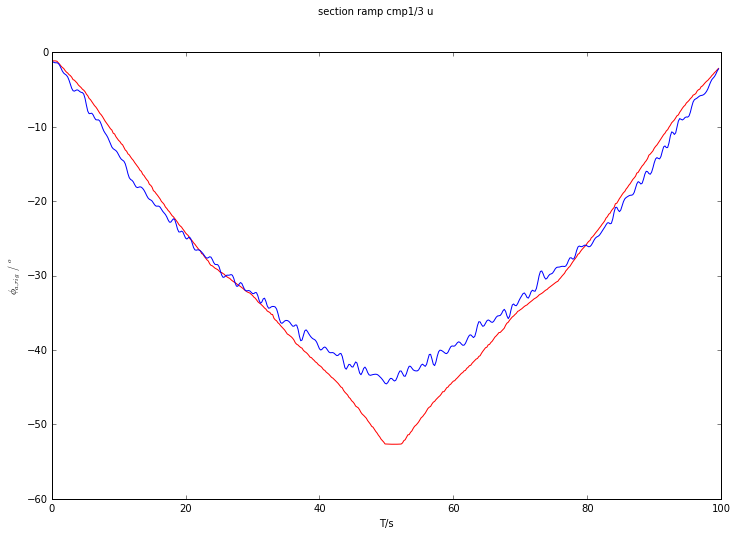

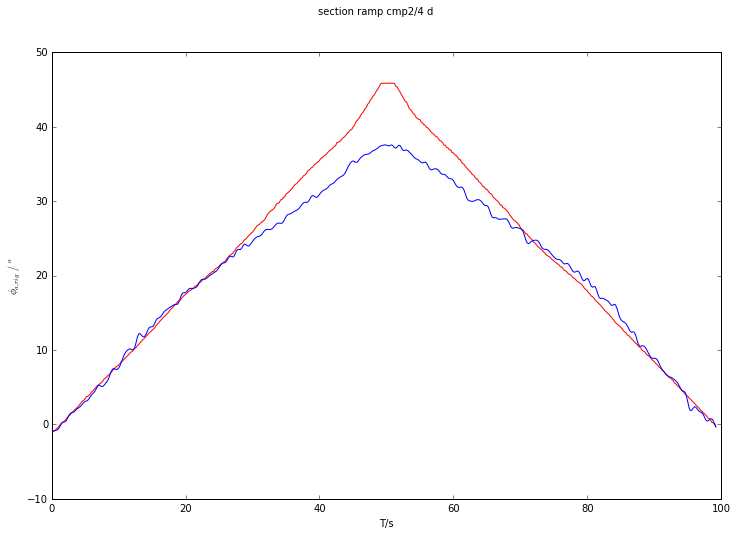

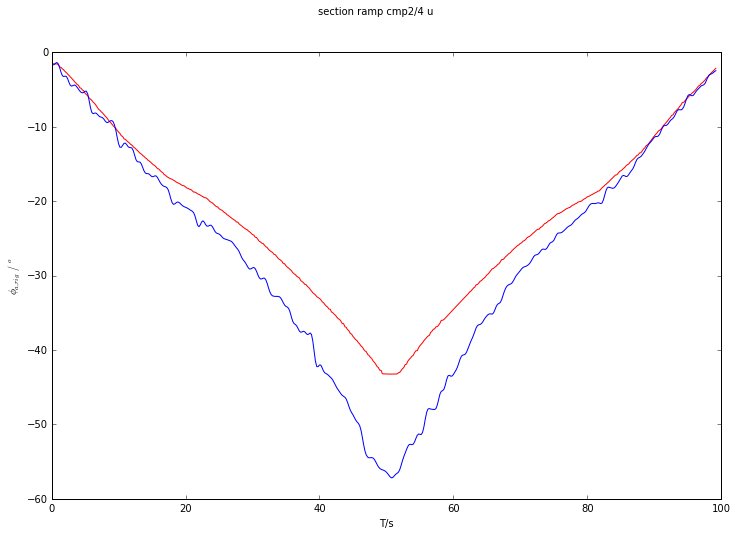

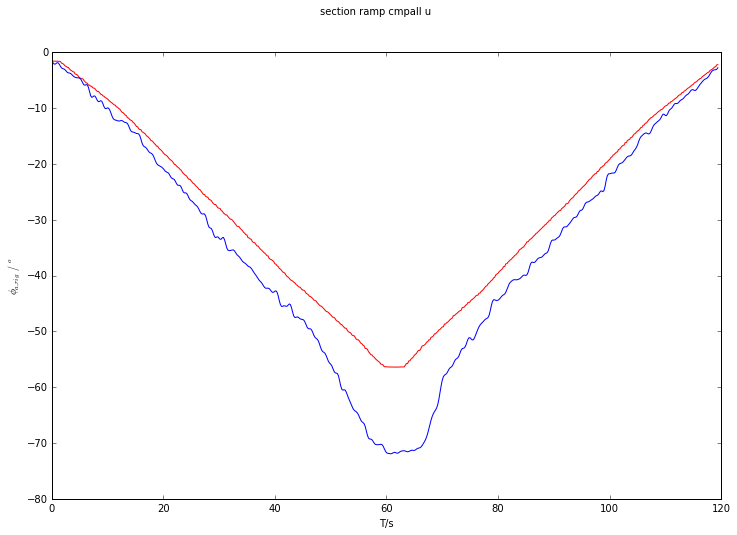

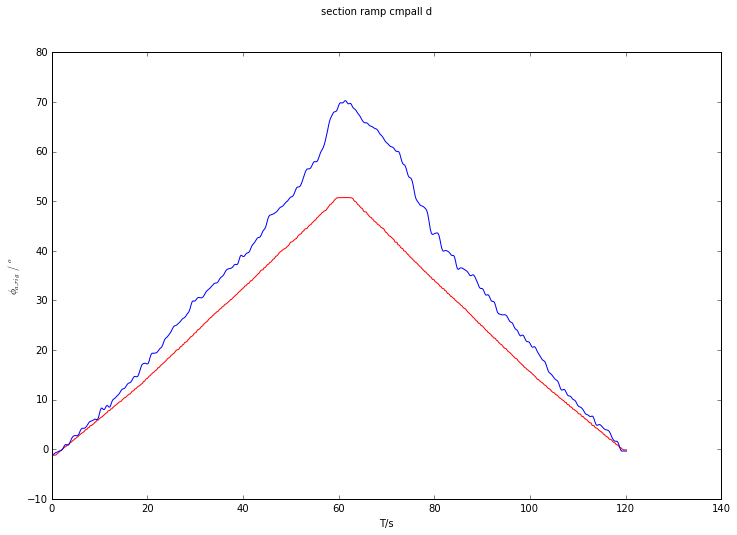

In [19]:
display_opt_params()

# show result
idx = range(len(time_marks))
display_data_for_test();

update_guess();

angeles = 
[-41, -35, -30, -25, -20, -15, -10, -5, 5, 10, 15, 20, 25, 30, 35, 41]
Clda_cmpx = 
[[ 0.05365201  0.04845049  0.04400308  0.03880643  0.03157759  0.02426385
   0.01593673  0.00671383 -0.00547453 -0.01632964 -0.02481085 -0.03168969
  -0.03386068 -0.03993892 -0.04471738 -0.04976543]
 [ 0.05306063  0.04529566  0.03882485  0.03235404  0.02588323  0.01941242
   0.01294162  0.00724062 -0.00487513 -0.01332038 -0.01909177 -0.02390146
  -0.02775267 -0.03284565 -0.03842749 -0.04574021]
 [ 0.03898716  0.03334067  0.02860633  0.02387216  0.01946238  0.01586664
   0.01288021  0.00689215 -0.00568404 -0.01106381 -0.01829239 -0.0247146
  -0.02992483 -0.03418391 -0.0376318  -0.04448086]
 [ 0.03990292  0.03159054  0.02932615  0.02524821  0.0203222   0.01758579
   0.01191278  0.00619895 -0.00566446 -0.01052614 -0.01485428 -0.01613583
  -0.02064422 -0.02524817 -0.02949545 -0.03552119]]


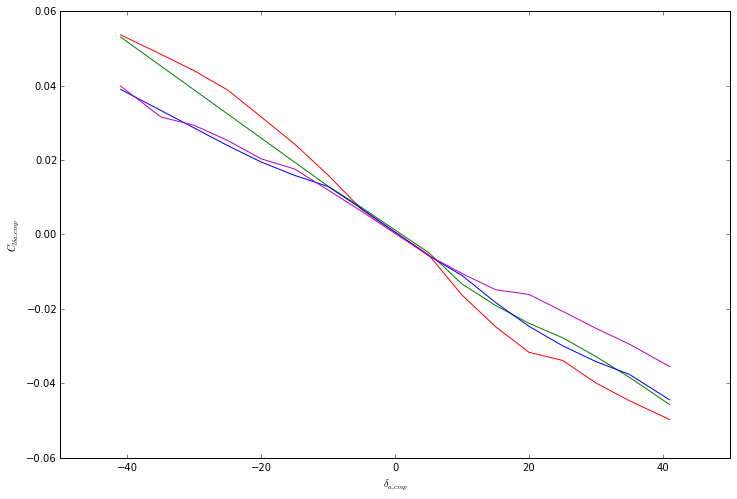

In [20]:
res_params = res['x']
params = param0[:]
for i,j in enumerate(opt_idx):
    params[j] = res_params[i]

k1 = np.array(params[0:angles_num])
k2 = np.array(params[angles_num:angles_num*2])
k3 = np.array(params[angles_num*2:angles_num*3])
k4 = np.array(params[angles_num*3:angles_num*4])

Clda_cmp1 = Clda_cmp*0.00436332313*k1*angles
Clda_cmp2 = Clda_cmp*0.00436332313*k2*angles
Clda_cmp3 = Clda_cmp*0.00436332313*k3*angles
Clda_cmp4 = Clda_cmp*0.00436332313*k4*angles

print('angeles = ')
print(angles)
print('Clda_cmpx = ')
print(np.vstack((Clda_cmp1,Clda_cmp2,Clda_cmp3,Clda_cmp4)))

%matplotlib inline
plt.figure(figsize=(12,8),dpi=300)
plt.plot(angles,  Clda_cmp1, 'r')
plt.plot(angles,  Clda_cmp2, 'g')
plt.plot(angles,  Clda_cmp3, 'b')
plt.plot(angles,  Clda_cmp4, 'm')
plt.xlabel('$\delta_{a,cmp}$')
plt.ylabel('$C_{l \delta a,cmp}$')
plt.show()

In [ ]:
toggle_inputs()
button_qtconsole()